In [ ]:
from NeuralNetwork import NN
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import random
import copy
import matplotlib.pyplot as plt

In [ ]:
#Seed für Reproduzierbarkeit
seed = 12345
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
#Festlegung exogener Variablen
η, b = 0.01, 50

μ, σ = 0, 1
n, d_input, d_output = 500, 1, 1
X = torch.normal(mean=μ, std=σ, size=(n, d_input))
Y = torch.normal(mean=μ, std=σ, size=(n, d_output))

plt.figure()
plt.scatter(X, Y, alpha=0.7)
plt.xlabel("X")
plt.ylabel("Y")

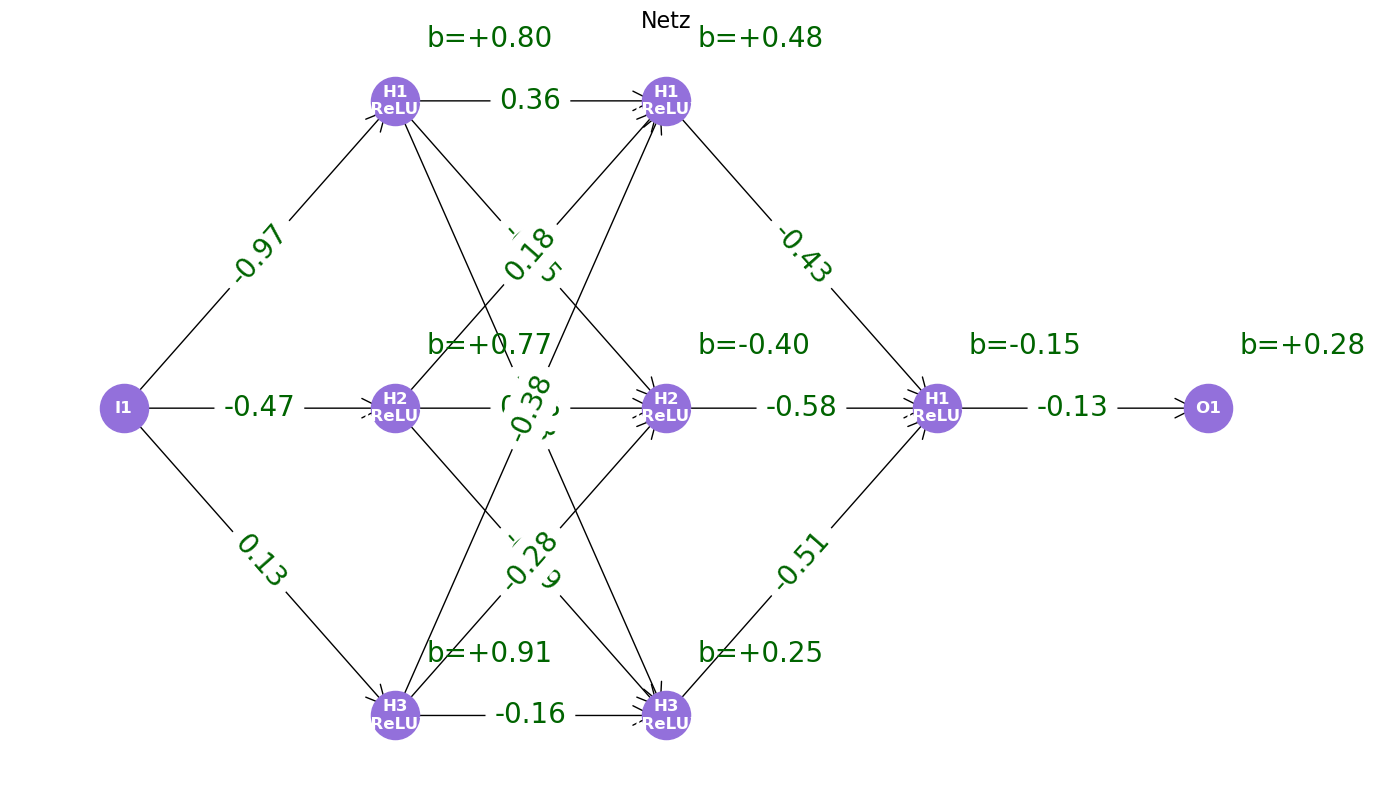

RuntimeError: mat1 and mat2 shapes cannot be multiplied (500x1 and 3x1)

In [5]:
#Modell und Ausgangskonfiguration 
model = NN()
model.visualize()
Y_hat = model(X)

θ0 = model.get_θ()
#print(θ0)

training_dataset = list(zip(X,Y))
#print(training_dataset)

In [ ]:
#Prognosefehler für Datenpunkte (x,y)
def loss_function(model, θ, X, Y, loss):
    model_copy = copy.deepcopy(model)
    model_copy.replace_θ(θ)
    Y_fitted = model_copy(X)

    accumulated_loss = 0
    for i in range(len(X)):
        y_fit = Y_fitted[i]
        y = Y[i]
        accumulated_loss += loss(y_fit, y)
    result = (1/len(X)) * accumulated_loss
    return result

In [8]:
#
def forward_with_θ(model, X, θ):
    idx = 0
    out = X
    for module in model.netz:
        if isinstance(module, nn.Linear):
            W = θ[idx]
            bias = θ[idx + 1]
            out = out @ W.T + bias
            idx += 2
        else:
            out = module(out)
    return out

def loss_function_grad(model, θ, X, Y, loss_fn):
    θ_diff = [w.detach().clone().requires_grad_(True) for w in θ]

    Y_hat = forward_with_θ(model, X, θ_diff)
    #model.replace_θ(θ_diff)
    #Y_hat = model(X)
    loss_val = loss_fn(Y_hat, Y)
    loss_val.backward()

    grads = [w.grad for w in θ_diff]
    return grads

In [9]:
def stochastic_gradient_descent(model, θ0, training_dataset, loss, η, b):
        data_shuffled = training_dataset[:]         
        random.shuffle(data_shuffled)  
        batch_samples = [data_shuffled[i:i+b] for i in range(0, len(training_dataset), b)]
        
        θ = θ0
        loss_history = []

        i = 1
        for batch in batch_samples:
            #print()
            #print("batch_" + str(i) + " :")
            X_batch = torch.stack([x for x, y in batch])
            Y_batch = torch.stack([y for x, y in batch])
            #print(X_batch)
            #print(Y_batch)

            grads = loss_function_grad(model, θ, X_batch, Y_batch, loss)
            #print()
            #print("g_" + str(i) + " :")
            #print(grads)
            θ_before = θ
            θ = [θ_i - η * g_i for θ_i, g_i in zip(θ, grads)]
            #print()
            #print("θ_" + str(i) + ":")
            #print(θ)
            loss_history.append(loss(model(X_batch), Y_batch).item())
            i += 1
        plt.plot(loss_history)
        return θ

In [10]:
def rss(Y_hat, Y):
    return ((Y_hat - Y) ** 2).sum()
def mse(Y_hat, Y):
    diff = Y_hat - Y
    return torch.mean(diff * diff)

In [11]:
error_before = float((rss(Y_hat, Y)).detach())
#print(error_before)
#print("training dataset:")
#print(training_dataset)

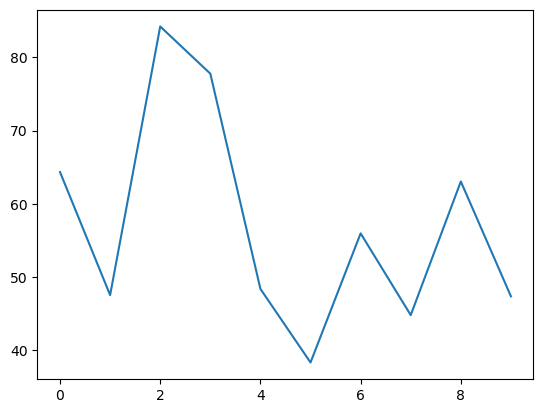

In [12]:
θ1 = stochastic_gradient_descent(model, θ0, training_dataset, rss, η, b)
#print(θ1)
# Guard: Parameter dürfen nicht riesig sein und SHAPEs müssen stimmen
for t in θ1:
    assert t.dtype.is_floating_point and t.ndim in (1,2), "θ-Element kaputt"
    assert t.abs().max().item() < 1e3, "θ explodiert – vermutlich doch Grad statt θ"

model.replace_θ(θ1)

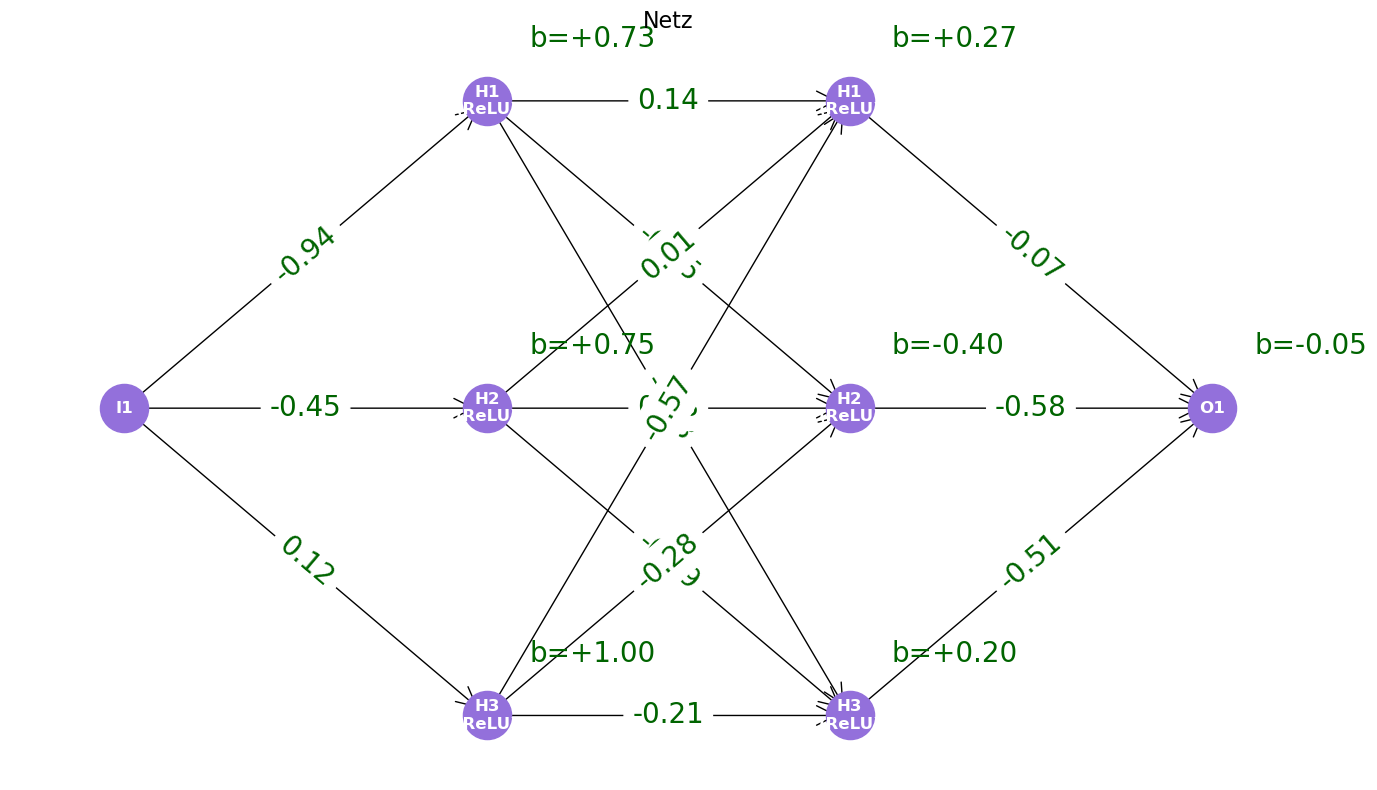

In [85]:
model.visualize()

In [13]:
Y_hat = model(X)

error_after = float((rss(Y_hat, Y)).detach())

#print(error_after)
print("Fehlerdifferenz: " + str(((error_after - error_before) / error_before) * 100) + "%")

Fehlerdifferenz: -19.770121432874618%


In [52]:
# ==============================
# Debug & Sanity Checks – kein Eingriff in SGD
# ==============================

from contextlib import contextmanager
import numpy as np

try:
    import torch
    import torch.nn.functional as F
    _HAS_TORCH = True
except Exception:
    _HAS_TORCH = False


# ---- Utilities: NumPy/Torch Handling ----
def _to_numpy(x):
    if _HAS_TORCH and isinstance(x, torch.Tensor):
        return x.detach().cpu().numpy()
    return np.asarray(x)

def _clone_like(x):
    if _HAS_TORCH and isinstance(x, torch.Tensor):
        return x.detach().clone()
    return np.array(x, copy=True)

def _flatten_params(theta_list):
    """
    Flacht eine Liste/Struktur von Parametern (z. B. [W1, b1, W2, b2]) zu 1D-Vektor ab
    und liefert eine Rekonstruktions-Funktion, die Torch-Dtype/Device beibehält.
    """
    types, shapes, dtypes, devices, flats = [], [], [], [], []
    for t in theta_list:
        if _HAS_TORCH and isinstance(t, torch.Tensor):
            arr = t.detach().cpu().numpy()
            types.append("torch"); dtypes.append(t.dtype); devices.append(t.device)
        else:
            arr = np.asarray(t)
            types.append("numpy"); dtypes.append(None); devices.append(None)
        shapes.append(arr.shape)
        flats.append(arr.ravel())
    flat = np.concatenate(flats) if flats else np.array([])

    def reconstruct(vec):
        pos = 0
        out = []
        for typ, shp, dt, dev in zip(types, shapes, dtypes, devices):
            size = int(np.prod(shp))
            chunk = vec[pos:pos+size].reshape(shp)
            pos += size
            if typ == "torch":
                out.append(torch.from_numpy(chunk).to(device=dev, dtype=dt))
            else:
                out.append(chunk.copy())
        return out
    return flat, reconstruct

@contextmanager
def deterministic(seed=0):
    """Fixiert Zufallsquellen für deterministische Tests."""
    state_np = np.random.get_state()
    if _HAS_TORCH:
        state_torch = torch.random.get_rng_state()
    np.random.seed(seed)
    if _HAS_TORCH:
        torch.manual_seed(seed)
    try:
        yield
    finally:
        np.random.set_state(state_np)
        if _HAS_TORCH:
            torch.random.set_rng_state(state_torch)


# ---- Loss & Helpers ----
def mse_numpy(y_hat, y):
    d = _to_numpy(y_hat) - _to_numpy(y)
    return float(np.mean(d*d))

def cosine_similarity(a, b, eps=1e-12):
    a = _to_numpy(a).ravel(); b = _to_numpy(b).ravel()
    na = np.linalg.norm(a); nb = np.linalg.norm(b)
    if na < eps or nb < eps: return 0.0
    return float(a.dot(b) / (na*nb))


# ---- Checks ----
def check_descent_direction(theta_list, forward_fn, grad_fn, X, y, loss_fn=mse_numpy, eps_list=(1e-8,1e-7,1e-6,1e-5)):
    """
    Prüft, ob der Gradient eine Abstiegsrichtung ist:
    L(θ - eps*g) < L(θ) für sehr kleine eps.
    - forward_fn(theta_list, X) -> y_hat
    - grad_fn(theta_list, X, y) -> Liste gleicher Struktur wie theta_list
    """
    theta0 = [ _clone_like(t) for t in theta_list ]
    L0 = float(loss_fn(forward_fn(theta0, X), y))
    g_list = grad_fn(theta0, X, y)
    g_flat, _ = _flatten_params([_to_numpy(g) for g in g_list])
    theta_flat, recon = _flatten_params([_to_numpy(t) for t in theta0])
    results = []
    for eps in eps_list:
        theta_try = theta_flat - eps * g_flat
        L_next = float(loss_fn(forward_fn(recon(theta_try), X), y))
        results.append((eps, L_next, L_next < L0))
    return L0, results

def one_step_sanity(theta_list, forward_fn, grad_fn, X, y, eta=1e-6, loss_fn=mse_numpy):
    """
    Ein einziger externer Update-Schritt (ohne deinen Trainingsloop):
    prüft, ob L(θ1) < L(θ0) auf demselben Batch gilt.
    """
    theta0 = [ _clone_like(t) for t in theta_list ]
    L0 = float(loss_fn(forward_fn(theta0, X), y))
    g_list = grad_fn(theta0, X, y)    # Erwartet MSE-Skalierung (über Batch gemittelt)!
    g_flat, recon = _flatten_params([_to_numpy(g) for g in g_list])
    theta_flat, _ = _flatten_params([_to_numpy(t) for t in theta0])
    theta1 = recon(theta_flat - eta * g_flat)
    L1 = float(loss_fn(forward_fn(theta1, X), y))
    return dict(L0=L0, L1=L1, improved=bool(L1 < L0),
                grad_norm=float(np.linalg.norm(g_flat)),
                step_norm=float(np.linalg.norm(eta * g_flat)))

def finite_diff_grad(theta_list, forward_fn, X, y, loss_fn=mse_numpy, epsilon=1e-5):
    """Numerischer Grad via zentralem Differenzenquotient (nur zur Validierung)."""
    theta0 = [ _clone_like(t) for t in theta_list ]
    theta_flat, recon = _flatten_params([_to_numpy(t) for t in theta0])
    num_g = np.zeros_like(theta_flat, dtype=float)
    for i in range(theta_flat.size):
        e = np.zeros_like(theta_flat); e[i] = epsilon
        Lp = float(loss_fn(forward_fn(recon(theta_flat + e), X), y))
        Lm = float(loss_fn(forward_fn(recon(theta_flat - e), X), y))
        num_g[i] = (Lp - Lm) / (2*epsilon)
    return num_g

def compare_analytical_vs_numeric_grad(theta_list, forward_fn, grad_fn, X, y, loss_fn=mse_numpy, epsilon=1e-5):
    """Vergleicht analytischen Grad mit numerischer Schätzung."""
    g_list = grad_fn(theta_list, X, y)
    g_flat, _ = _flatten_params([_to_numpy(g) for g in g_list])
    num_g = finite_diff_grad(theta_list, forward_fn, X, y, loss_fn, epsilon=epsilon)
    return dict(cosine=cosine_similarity(g_flat, num_g),
                max_abs_diff=float(np.max(np.abs(g_flat - num_g))))

def gradient_stats(theta_list, grad_fn, X, y):
    """Normen je Parameterblock + Gesamtgrad."""
    g_list = grad_fn(theta_list, X, y)
    norms = [ float(np.linalg.norm(_to_numpy(g))) for g in g_list ]
    total = float(np.linalg.norm(np.concatenate([_to_numpy(g).ravel() for g in g_list])))
    return dict(block_norms=norms, total_norm=total)



In [53]:
# ---- Functional Forward/Grad für dein 1-3-1 Netz (ReLU) ----
# Erwartete θ-Reihenfolge: [W1, b1, W2, b2]
# Shapes: W1:(3,1), b1:(3,), W2:(1,3), b2:(1,)

import torch
import torch.nn.functional as F

def _to_torch_param(p, like=None):
    """Konvertiert p zu torch.Tensor, hält dtype/device konsistent."""
    if isinstance(p, torch.Tensor):
        return p
    dt = like.dtype if (like is not None and isinstance(like, torch.Tensor)) else torch.float32
    dev = like.device if (like is not None and isinstance(like, torch.Tensor)) else "cpu"
    return torch.as_tensor(p, dtype=dt, device=dev)

def functional_forward(theta_list, X):
    """
    Rechnet dein Netz rein funktional, unabhängig vom Trainingscode.
    Akzeptiert θ als Torch oder NumPy.
    """
    # zu Torch konvertieren (robust ggü. NumPy-Input)
    W1 = _to_torch_param(theta_list[0])
    b1 = _to_torch_param(theta_list[1], like=W1)
    W2 = _to_torch_param(theta_list[2], like=W1)
    b2 = _to_torch_param(theta_list[3], like=W1)

    X = X if isinstance(X, torch.Tensor) else torch.as_tensor(X, dtype=W1.dtype, device=W1.device)

    h = X @ W1.t() + b1        # (N,3)
    h = F.relu(h)
    y_hat = h @ W2.t() + b2    # (N,1)
    return y_hat

def grad_theta(theta_list, X, y, loss_reduction="mean"):
    """
    Autograd-Gradienten bzgl. theta_list. Verwendet MSE (mean oder sum).
    Gibt eine Liste gleicher Struktur wie theta_list zurück.
    """
    W1, b1, W2, b2 = theta_list
    W1g = _to_torch_param(W1).detach().clone().requires_grad_(True)
    b1g = _to_torch_param(b1, like=W1g).detach().clone().requires_grad_(True)
    W2g = _to_torch_param(W2, like=W1g).detach().clone().requires_grad_(True)
    b2g = _to_torch_param(b2, like=W1g).detach().clone().requires_grad_(True)

    y_hat = functional_forward([W1g, b1g, W2g, b2g], X)
    y_t = y if isinstance(y, torch.Tensor) else torch.as_tensor(y, dtype=y_hat.dtype, device=y_hat.device)

    diff = y_hat - y_t
    if loss_reduction == "mean":
        loss = torch.mean(diff*diff)
    elif loss_reduction == "sum":
        loss = torch.sum(diff*diff)
    else:
        raise ValueError("loss_reduction must be 'mean' or 'sum'")
    loss.backward()
    return [W1g.grad.detach(), b1g.grad.detach(), W2g.grad.detach(), b2g.grad.detach()]

# Aliasse für die Debug-Suite:
forward_fn = functional_forward
grad_fn = grad_theta

def get_theta_from_model(model):
    """
    Extrahiert [W1, b1, W2, b2] aus einem torch.nn-Modell mit Architektur Linear->ReLU->Linear.
    """
    W1 = b1 = W2 = b2 = None
    for m in model.modules():
        if isinstance(m, torch.nn.Linear):
            if W1 is None:
                W1 = m.weight.detach().clone(); b1 = m.bias.detach().clone()
            else:
                W2 = m.weight.detach().clone(); b2 = m.bias.detach().clone()
    if any(v is None for v in (W1, b1, W2, b2)):
        raise RuntimeError("Konnte θ nicht extrahieren. Stimmt die Architektur (Linear→ReLU→Linear)?")
    return [W1, b1, W2, b2]

# === Debug: eta-sweep (kein Eingriff in Training) ===
def eta_sweep(theta, X, y, alphas=(5e-6,1e-5,2e-5,5e-5,1e-4,2e-4,5e-4)):
    # Grad am aktuellen θ
    g_list = grad_fn(theta, X, y)
    g_flat, recon = _flatten_params([_to_numpy(g) for g in g_list])
    theta_flat, _ = _flatten_params([_to_numpy(t) for t in theta])

    L0 = mse_numpy(forward_fn(theta, X), y)
    print(f"L0 = {L0:.6g}")

    best = None
    for a in alphas:
        th_try = recon(theta_flat - a * g_flat)
        L = mse_numpy(forward_fn(th_try, X), y)
        mark = "  <-- best" if best is None or L < best[1] else ""
        if best is None or L < best[1]:
            best = (a, L)
        print(f"eta={a:>8g} -> L={L:.6g}{mark}")
    print("Best:", best)

# Beispiel: am Startpunkt oder an θ¹ prüfen
# eta_sweep(theta_list, X_debug, y_debug)


# Optional: falls bereits 'model = NN()' existiert, θ automatisch beziehen
try:
    theta_list = get_theta_from_model(model)
except NameError:
    theta_list = None


In [54]:
# Setze hier deinen Debug-Batch. Falls nicht vorhanden, wird ein Dummy genutzt.
import torch



if 'X_debug' not in globals() or X_debug is None:
    X_debug = torch.tensor([[0.0],[1.0],[2.0],[3.0]])
    y_debug = torch.tensor([[0.0],[1.0],[2.0],[3.0]])

# Falls kein theta_list vorhanden: von vorhandenem Modell oder frischem NN holen
if 'theta_list' not in globals() or theta_list is None:
    try:
        model  # existiert ein Modellobjekt?
        theta_list = get_theta_from_model(model)
    except NameError:
        _tmp = NN()
        theta_list = get_theta_from_model(_tmp)

theta_list = θ0

with deterministic(0):
    print("== Check 1: Descent Direction ==")
    L0, res = check_descent_direction(theta_list, forward_fn, grad_fn, X_debug, y_debug, loss_fn=mse_numpy)
    print("L0:", L0)
    for eps, L_next, ok in res:
        print(f"  eps={eps:.0e} -> L={L_next:.6g}  {'OK' if ok else 'NOT DESCENT'}")

    print("\n== Check 2: One-Step Sanity (kleines eta) ==")
    info = one_step_sanity(theta_list, forward_fn, grad_fn, X_debug, y_debug, eta=1e-6, loss_fn=mse_numpy)
    for k,v in info.items():
        print(f"{k}: {v}")

    print("\n== Check 3: Gradientvergleich (analytisch vs. numerisch) ==")
    cmpres = compare_analytical_vs_numeric_grad(theta_list, forward_fn, grad_fn, X_debug, y_debug, loss_fn=mse_numpy, epsilon=1e-5)
    print("cosine:", cmpres["cosine"], "  max|diff|:", cmpres["max_abs_diff"])

    print("\n== Check 4: Gradienten-Normen ==")
    gstats = gradient_stats(theta_list, grad_fn, X_debug, y_debug)
    print("Block-Normen:", gstats["block_norms"])
    print("Gesamt-Norm :", gstats["total_norm"])

    eta_sweep(theta_list, X_debug, y_debug)

== Check 1: Descent Direction ==


ValueError: too many values to unpack (expected 4)